In [28]:
import datetime
import numpy as np
import pandas as pd
import pylab as pl
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
from hmmlearn.hmm import GaussianHMM
import pandas_datareader.data as fetch
from matplotlib import cm, pyplot as plt, finance
from __future__ import print_function

In [29]:
def close_price(symbols, start_date, end_date):
    stock_close_price = pd.DataFrame()
    for s in symbols:
        data = fetch.DataReader(s, 'yahoo', start_date, end_date)
        stock_close_price[s] = data['Close']
    return stock_close_price

In [30]:
def volume_stock(symbols, start_date, end_date):
    stock_volume_df = pd.DataFrame()
    for s in symbols:
        data = fetch.DataReader(s, 'yahoo', start_date, end_date)
        stock_volume_df[s] = data['Volume']
    return stock_volume_df

In [43]:
start_date = datetime.datetime(2007, 1, 1)
end_date = datetime.date.today() - datetime.timedelta(days=15)
symbols = ['AAPL']
close_price_portfolio = close_price(symbols, start_date, end_date)
volume_portfolio = volume_stock(symbols, start_date, end_date)

In [44]:
close_price_portfolio.reset_index(inplace=True,drop=False)
volume_portfolio.reset_index(inplace=True,drop=False)

In [45]:
final_df = close_price_portfolio
final_df.columns = ['Date', 'Close']
final_df['Volume'] = volume_portfolio['AAPL']
final_df['Date'] = final_df['Date'].apply(datetime.datetime.toordinal)
quotes = list(final_df.itertuples(index=False, name=None))

In [46]:
dates = np.array([q[0] for q in quotes], dtype=int)
close_v = np.array([q[1] for q in quotes])
volume = np.array([q[2] for q in quotes])[1:]

In [47]:
diff = np.diff(close_v)
dates = dates[1:]
close_v = close_v[1:]

In [48]:
X = np.column_stack([diff, volume])

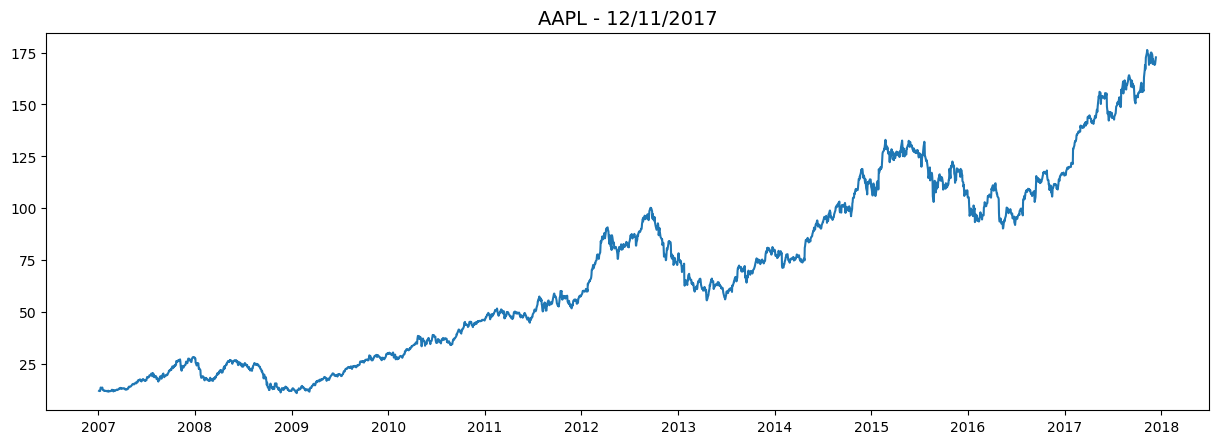

In [49]:
plt.figure(figsize=(15, 5), dpi=100) 
plt.title('AAPL' + " - " + end_date.strftime("%m/%d/%Y"), fontsize = 14)
plt.gca().xaxis.set_major_locator(YearLocator())
plt.plot_date(dates,close_v,"-")
plt.show()

In [50]:
###############################################################################
# Run Gaussian HMM
###############################################################################
print("fitting to HMM and decoding ...", end="")
# Make an HMM instance and execute fit
model = GaussianHMM(n_components=4, covariance_type="diag", n_iter=1000).fit(X)
# Predict the optimal sequence of internal hidden state
hidden_states = model.predict(X)
print("done")

fitting to HMM and decoding ...

/home/pavan/anaconda3/envs/ubuntu_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


done


In [51]:
###############################################################################
# Print trained parameters and plot
###############################################################################
print("Transition matrix - probability of going to any particular state")
print(model.transmat_)

print("Means and vars of each hidden state")
params = pd.DataFrame(columns=('State', 'Means', 'Variance'))
for i in range(model.n_components):
    params.loc[i] = [format(i), model.means_[i],np.diag(model.covars_[i])]
print(params)

Transition matrix - probability of going to any particular state
[[  9.44109582e-01   3.48545688e-02   2.53974782e-03   1.84961009e-02]
 [  1.11688746e-01   7.14645220e-01   3.84555566e-02   1.35210477e-01]
 [  1.51144143e-04   1.35294519e-02   9.86319404e-01   1.81513266e-57]
 [  3.96102724e-02   5.25159621e-02   1.40571074e-44   9.07873765e-01]]
Means and vars of each hidden state
  State                             Means                             Variance
0     0  [0.0912245068221, 101120881.171]  [0.574033568155, 8.57056870708e+14]
1     1  [-0.187093914247, 293668847.757]   [4.81697787331, 1.96024649634e+16]
2     2   [0.103023297188, 39923143.5844]   [2.23688373541, 2.75700578802e+14]
3     3  [0.0510671753636, 205418756.975]  [0.267808909304, 3.12266649439e+15]


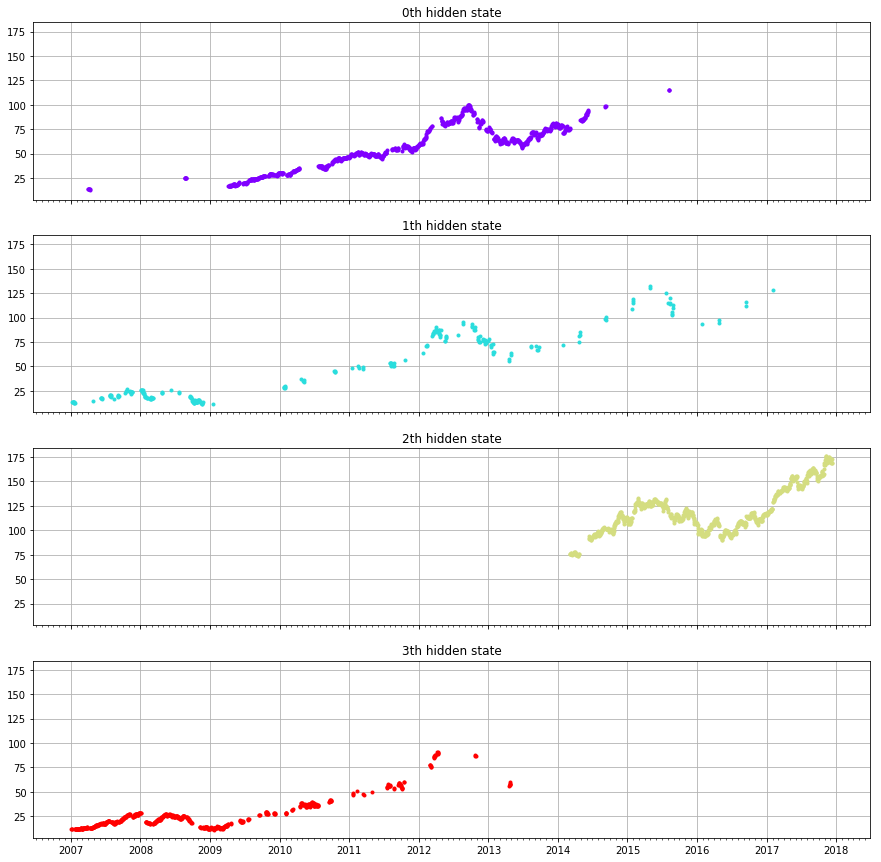

In [52]:
fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True, figsize=(15,15))
colours = cm.rainbow(np.linspace(0, 1, model.n_components))

for i, (ax, colour) in enumerate(zip(axs, colours)):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    ax.plot_date(dates[mask], close_v[mask], ".", c=colour)
    ax.set_title("{0}th hidden state".format(i))

    # Format the ticks.
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())

    ax.grid(True)
plt.show()

In [53]:
#dot product Transition Matrix to Means to get the expected return and volumes for a particular state
expected_returns_and_volumes = np.dot(model.transmat_, model.means_)
returns_and_volume_columnwise = list(zip(*expected_returns_and_volumes))
expected_returns = returns_and_volume_columnwise[0]
expected_volumes = returns_and_volume_columnwise[1]
params = pd.concat([pd.Series(expected_returns), pd.Series(expected_volumes)], axis=1)
params.columns= ['Returns', 'Volume']
print (params)

    Returns        Volume
0  0.080811  1.096057e+08
1 -0.112650  2.504731e+08
2  0.099096  4.336543e+07
3  0.040151  2.059220e+08


In [56]:
#get quotes for last N days
lastN = 7
start_date_lastN = datetime.date.today() - datetime.timedelta(days=lastN*2) #even beyond N days
end_date_lastN = datetime.date.today()
close_price_portfolio = close_price(symbols, start_date, end_date)
volume_portfolio = volume_stock(symbols, start_date, end_date)
close_price_portfolio.reset_index(inplace=True,drop=False)
volume_portfolio.reset_index(inplace=True,drop=False)
final_df = close_price_portfolio
final_df.columns = ['Date', 'Close']
final_df['Volume'] = volume_portfolio['AAPL']
final_df['Date'] = final_df['Date'].apply(datetime.datetime.toordinal)
quotes = list(final_df.itertuples(index=False, name=None))
dates = np.array([q[0] for q in quotes], dtype=int)#get quotes for last N days

In [57]:
predicted_prices = []
predicted_dates = []
predicted_volumes = []
actual_volumes = []

for idx in range(lastN):
    state = hidden_states[-lastN+idx]
    current_price = quotes[-lastN+idx][2]
    volume = quotes[-lastN+idx][5]
    actual_volumes.append(volume)
    current_date = datetime.date.fromordinal(dates[-lastN+idx])
    predicted_date = current_date + datetime.timedelta(days=1)
    predicted_dates.append(predicted_date)
    predicted_prices.append(current_price + expected_returns[state])
    predicted_volumes.append(np.round(expected_volumes[state]))    

#Returns
plt.figure(figsize=(15, 5), dpi=100) 
plt.title(ticker, fontsize = 14)
plt.plot(predicted_dates,close_v[-lastN:])
plt.plot(predicted_dates,predicted_prices)
plt.legend(['Actual','Predicted'])
plt.show()

#Volumes
plt.figure(figsize=(15, 5), dpi=100) 
plt.title(ticker, fontsize = 14)
plt.plot(predicted_dates,actual_volumes)
plt.plot(predicted_dates,predicted_volumes)
plt.legend(['Actual','Predicted'])
plt.show()

IndexError: tuple index out of range

In [44]:
close_price_portfolio.reset_index(inplace=True,drop=False)
volume_portfolio.reset_index(inplace=True,drop=False)

In [45]:
final_df = close_price_portfolio
final_df.columns = ['Date', 'Close']
final_df['Volume'] = volume_portfolio['AAPL']
final_df['Date'] = final_df['Date'].apply(datetime.datetime.toordinal)
quotes = list(final_df.itertuples(index=False, name=None))